# Modello convolutivo di base
Di seguito verrà creato un **modello convolutivo di base** con un'architettura semplice. In seguito, sarà interessante confrontare i risultati di questo primo modello con i risultati ottenuti da modelli più complessi, o pre addestrati.

Come è solito, si procede con l'importazione delle librerie utilizzate e la creazione dei set di allenamento e validazione.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
for audios, labels in train_ds:
    print("Forma (shape) audio:", audios.shape)
    print("Forma (shape) classi:", labels.shape)
    break

Forma (shape) audio: (32, 16000, 1)
Forma (shape) classi: (32,)


Lo shape dell'audio è di (32, 16000, 1), indicando che ogni file è contenuto in un batch di 32 tensori unidimensionali di lunghezza 16000. Inoltre, lo shape delle classi è anch'esso 32. Questo perché la funzione `tf.keras.utils.audio_dataset_from_directory(directory)` ha il parametro `batch_size` impostato a 32 di default, non avendolo specificato la dimensione è rimasta tale.

## Funzioni per processamento dei dati

Il prossimo step è definire la funzione `squeeze(audio, labels)`, la quale prende come argomenti l'audio e le classi.

Questo funzione serve per rimuovere l'ultimo asse dello shape dai nostri audio. Attualmente, lo shape dei dati è (32, 16000, 1), ma si può eliminare l'ultima dimensione poiché non necessaria. Specificando il parametro **axis=-1** nella funzione `tf.squeeze` la forma dell'audio viene trasformata in (32, 16000).

Eseguiamo questa semplificazione sulla forma del dato poiché rende la fase di processamento dei dati più efficiente.

In [4]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Una volta eseguito questa semplificazione, a partire dai tensori degli audio, creeremo gli spettrogrammi che sarannò presi come input dal modello convolutivo.

## Conversione e suddivisione dataset
Andremo ad utilizzare due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Queste due funzioni usate insieme creano un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [6]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [7]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro training set, validation set, e test set di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [8]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [9]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


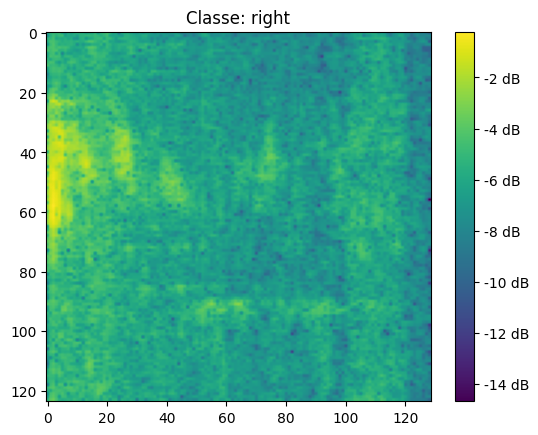

In [10]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)

    spectrogram = np.squeeze(audio[0])
    spectrogram = np.log(spectrogram.T)

    plt.imshow(spectrogram.T)
    plt.colorbar(format='%+2.0f dB')

    plt.title(f"Classe: {label_names[label[0].numpy()]}")
    break

La grandezza degli spettrogrammi, quindi delle immagini ottenute, è di **124x129**.

## Creazione modello di base

Come primo modello implementiamo una rete neurale convolutiva. Questo modello ha un'architettura semplice e servirà da benchmark per i modelli futuri.

La rete prende in ingresso tensori di forma altezza x larghezza x canali, rispettivamente di 124, 129, 1. Per farlo lavorare meglio, rendiamo le immagini di mensione quadrate e normalizziamo i dati con la funzione `tf.keras.layers.Normalization()`.
L'architettura si basa su blocchi di due strati convolutivi con attivazione `ReLu` per aggiungere non linearità, seguiti da uno strato maxpooling.

In [11]:
def get_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Resizing(120, 120)(inputs)
    x = tf.keras.layers.Normalization()(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
basic_model = get_basic_model()
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 120, 120, 1)       0         
                                                                 
 normalization (Normalizati  (None, 120, 120, 1)       3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 58, 58, 32)        0         
 D)                                                          

La dimensione dell'output dell'ultimo livello convolutivo è di (None, 25, 25, 256), cioè **256** feature maps di dimensione **25 x 25**. Eseguiamo il livello `Flatten` per vettorizzare le feature map, cosi da poterle passare in ingresso al livello `Dense`. Utilizziamo la funzione di attivazione softmax perché il task è di classificazione multiclasse, con 30 classi di output. Il modello ha un totale di circa **5 milioni di parametri**, bilanciando complessità e capacità di apprendimento.

In [13]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 11s 24ms/step - loss: 2.3709 - accuracy: 0.3611 - val_loss: 1.5070 - val_accuracy: 0.5783
Epoch 2/30
243/243 [==============================] - 5s 20ms/step - loss: 1.0225 - accuracy: 0.7222 - val_loss: 1.2660 - val_accuracy: 0.7184
Epoch 3/30
243/243 [==============================] - 5s 20ms/step - loss: 0.5164 - accuracy: 0.8577 - val_loss: 1.2154 - val_accuracy: 0.7573
Epoch 4/30
243/243 [==============================] - 5s 19ms/step - loss: 0.2670 - accuracy: 0.9249 - val_loss: 3.1608 - val_accuracy: 0.6562
Epoch 5/30
243/243 [==============================] - 5s 19ms/step - loss: 0.1743 - accuracy: 0.9517 - val_loss: 1.7826 - val_accuracy: 0.7531
Epoch 6/30
243/243 [==============================] - 5s 19ms/step - loss: 0.1328 - accuracy: 0.9666 - val_loss: 2.0696 - val_accuracy: 0.7492
Epoch 7/30
243/243 [==============================] - 5s 19ms/step - loss: 0.0939 - accuracy: 0.9758 - val_loss: 2.0958 - val_accuracy: 0.756

Alleniamo il modello per 30 epoche e visualizziamo le **curve di addestramento** e **validazione**.

In [14]:
def create_train_val_plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Accuratezza in addestramento")
    plt.plot(epochs, val_accuracy, "b", label="Accuratezza in validazione")
    plt.title("Accuratezza in addestramento e validazione")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "bo", label="Loss in addestramento")
    plt.plot(epochs, val_loss, "b", label="Loss in validazione")
    plt.title("Loss in addestramento e validazione")
    plt.legend()

    plt.show()

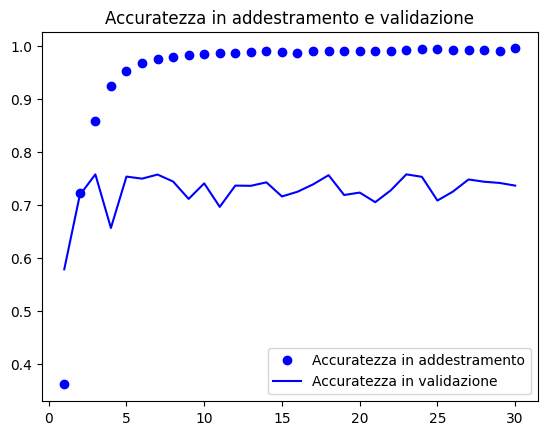

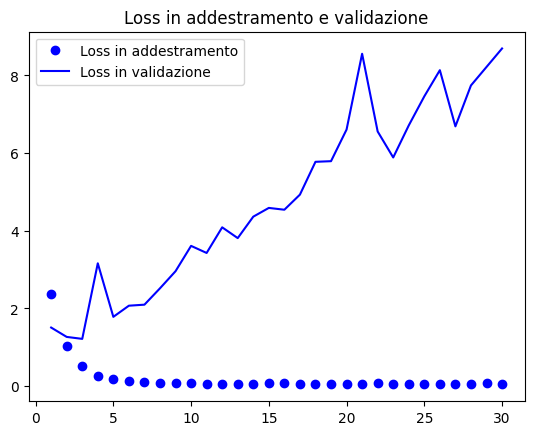

In [15]:
create_train_val_plot(basic_model_history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione varia dal **70% al 80%** con un picco del 78%. Inoltre, la **perdita nel set di addestramento** continua a diminuire mentre la **perdita nel set di validazione** aumenta.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**.

In [16]:
best_basic_model = tf.keras.models.load_model("bestmodels/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 12ms/step - loss: 1.3274 - accuracy: 0.7303
Accuratezza: 0.730


Abbiamo ottenuto un'**accuratezza** del **XX%**! Considerata la complessità del task non è male.

Infine, creiamo una funzione utile a visualizzare graficamente la distribuzione di accuratezza delle classi su un'immagine casuale, per capire come ha lavorato il modello. Nel caso il modello non predica correttamente, la **classe corretta** verrà sempre evidenziata di **verde** mentre la **classe predetta** verrà evidenziata di **giallo**.

In [17]:
def create_distribution_plot(model, audio, label):
    prediction = model(audio)
    softmax_pred = tf.nn.softmax(prediction[0])
    pred_label = np.argmax(softmax_pred)

    colors = ['indianred'] * len(label_names)

    if pred_label == label[0].numpy():
        colors[pred_label] = 'seagreen'
    else:
        colors[pred_label] = 'khaki'
        colors[label[0].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    if pred_label == label[0].numpy():
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

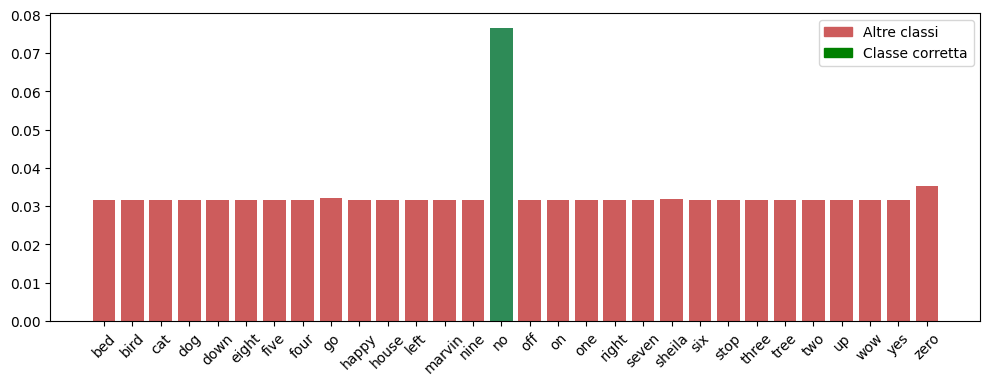

In [18]:
for audio, label in test_ds:
    create_distribution_plot(best_basic_model, audio, label)
    break

L'overfitting è probabilmente fortemente causato dal fatto che il nostro dataset contiene un numero insufficente di campioni, rendendolo non in grado di generalizzare su dati nuovi. Per migliorare la capacità di generalizzare del modello andremo a creare dei dati artificali con le tecniche di data agumentation.

## Overfitting
Abbiamo capito che il modello di base è andato immediatamente in overfitting, perciò l'idea in questo momento è evitare che vada in overfitting troppo velocemente e capire se le tecniche viste a lezione ci tornano utili anche con questo task.

Come prima tecnica cercheremo di aumentare il numero di campioni da cui apprendere, così da cercare di creare un modello che sia in grado di generalizzare meglio sui nuovi dati.

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
    # tf.keras.layers.RandomZoom(0.2) # -> non ci stava dando risultati e raddoppiava il tempo di training (40s in totale per epoca)
    # tf.keras.layers.RandomTranslation(height_factor=5/124, width_factor=0)
    # tf.keras.layers.RandomTranslation(height_factor=0, width_factor=5/129)
    # questi ultimi due layer non ci stavano dando risultati e aumentava di molto il tempo di training (1:30 minuti per epoca)
    # l'idea era quella di traslare le immagini di 5 pixel per la X e 5 pixel per la Y
])

In [20]:
def get_improved_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)
    x = tf.keras.layers.Normalization()(x)

    # Livelli per l'apprendimento della rappresentazione delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
improved_basic_model = get_improved_basic_model()
improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

improved_basic_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 124, 129, 1)       0         
                                                                 
 resizing_1 (Resizing)       (None, 120, 120, 1)       0         
                                                                 
 normalization_1 (Normaliza  (None, 120, 120, 1)       3         
 tion)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 118, 118, 16)      160       
                                                                 
 conv2d_6 (Conv2D)           (None, 116, 116, 32)      4640      
                                                           

In [22]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 8s 22ms/step - loss: 3.2498 - accuracy: 0.0946 - val_loss: 2.9956 - val_accuracy: 0.1312
Epoch 2/100
243/243 [==============================] - 5s 22ms/step - loss: 2.8465 - accuracy: 0.2059 - val_loss: 2.7264 - val_accuracy: 0.2928
Epoch 3/100
243/243 [==============================] - 5s 22ms/step - loss: 2.4418 - accuracy: 0.3249 - val_loss: 2.3559 - val_accuracy: 0.3480
Epoch 4/100
243/243 [==============================] - 5s 22ms/step - loss: 2.1513 - accuracy: 0.3982 - val_loss: 1.8185 - val_accuracy: 0.4823
Epoch 5/100
243/243 [==============================] - 5s 22ms/step - loss: 1.9222 - accuracy: 0.4698 - val_loss: 1.5570 - val_accuracy: 0.5525
Epoch 6/100
243/243 [==============================] - 5s 22ms/step - loss: 1.7529 - accuracy: 0.5184 - val_loss: 1.5027 - val_accuracy: 0.5694
Epoch 7/100
243/243 [==============================] - 5s 22ms/step - loss: 1.6065 - accuracy: 0.5514 - val_loss: 1.4963 - val_accuracy:

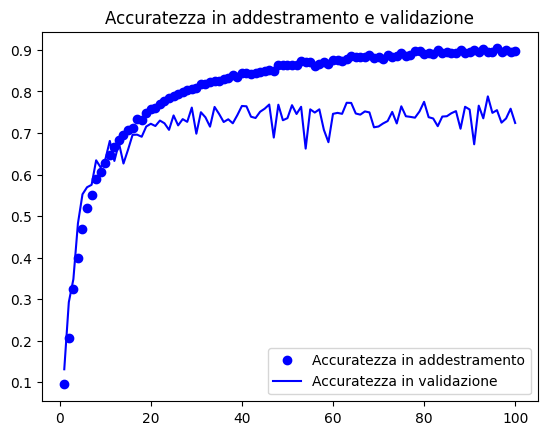

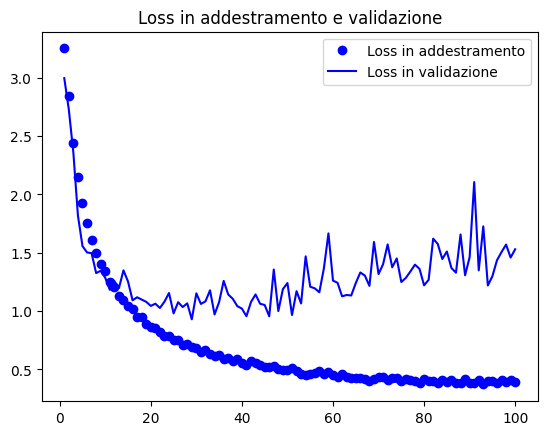

In [23]:
create_train_val_plot(improved_history)

In [24]:
improved_best_model = tf.keras.models.load_model("bestmodels/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 8ms/step - loss: 1.0379 - accuracy: 0.7330
Accuratezza: 0.733


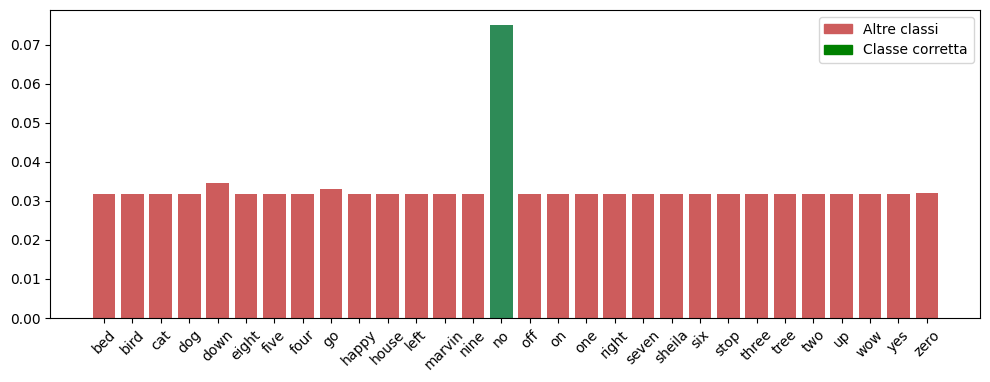

In [25]:
for audio, label in test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

## Miglioramenti all'architettura del modello

Durante il corso abbiamo visto anche delle best practice architetturali che possono aiutare a ottenere maggiori prestazioni col modello. Il nostro obbiettivo non è creare un modello troppo avanzato, ma nemmeno troppo basilare. Il nostro scopo è provare le tecniche viste e studiate durante il corso e capire come reagiscono al task.

La differenza tra queste tecniche e quelle viste nel paragrafo precedente è l'obbiettivo. Prima volevamo evitare che il nostro modello andasse in overfitting troppo velocemente, adesso invece stiamo applicando delle best-practice per apprendere efficaciemente dai dati.

### Blocchi residuali
I blocchi residuali sono la prima delle tre tecniche che utilizzeremo. BLA BLA BLA

In [32]:
def residual_block(x, size):
    residual = x
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    residual = tf.keras.layers.Conv2D(size, 3, padding="same", use_bias=False)(residual)
    return tf.keras.layers.add([x, residual])


def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)

    x = residual_block(x, 16)

    x = residual_block(x, 32)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = residual_block(x, 64)

    x = residual_block(x, 128)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = residual_block(x, 256)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [33]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 129, 1)         0         ['input_5[0][0]']             
                                                                                                  
 resizing_4 (Resizing)       (None, 120, 120, 1)          0         ['sequential[3][0]']          
                                                                                                  
 separable_conv2d_10 (Separ  (None, 120, 120, 16)         25        ['resizing_4[0][0]']          
 ableConv2D)                                                                                

In [34]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 13s 42ms/step - loss: 3.4947 - accuracy: 0.0635 - val_loss: 3.3787 - val_accuracy: 0.0409
Epoch 2/100
243/243 [==============================] - 10s 42ms/step - loss: 3.2551 - accuracy: 0.0937 - val_loss: 3.1843 - val_accuracy: 0.1219
Epoch 3/100
243/243 [==============================] - 10s 41ms/step - loss: 3.1576 - accuracy: 0.1115 - val_loss: 3.2878 - val_accuracy: 0.0853
Epoch 4/100
243/243 [==============================] - 10s 41ms/step - loss: 3.0649 - accuracy: 0.1352 - val_loss: 3.2671 - val_accuracy: 0.1265
Epoch 5/100
243/243 [==============================] - 10s 42ms/step - loss: 2.9905 - accuracy: 0.1534 - val_loss: 2.9739 - val_accuracy: 0.1454
Epoch 6/100
243/243 [==============================] - 10s 42ms/step - loss: 2.9090 - accuracy: 0.1805 - val_loss: 2.6289 - val_accuracy: 0.2377
Epoch 7/100
243/243 [==============================] - 10s 41ms/step - loss: 2.8406 - accuracy: 0.2004 - val_loss: 2.8242 - val_ac

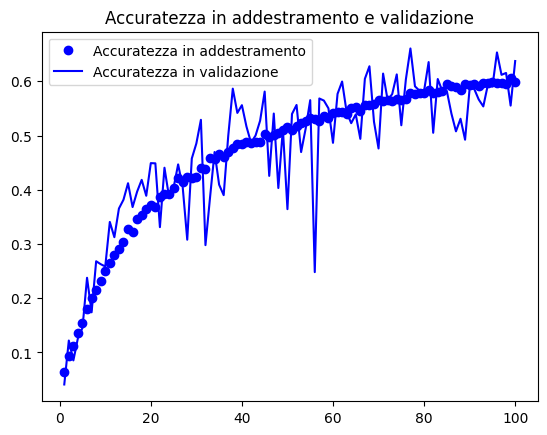

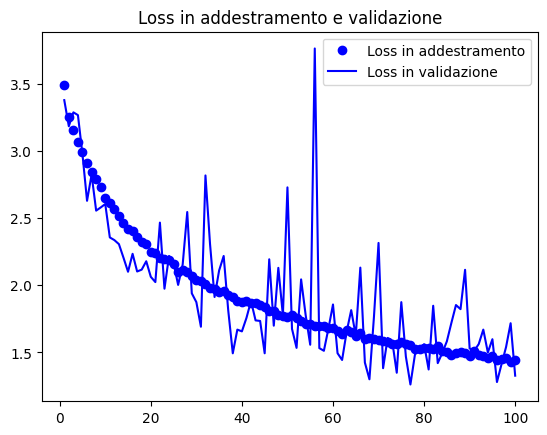

In [35]:
create_train_val_plot(bp_model_history)

In [36]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 2s 21ms/step - loss: 1.3742 - accuracy: 0.6474
Accuratezza: 0.647


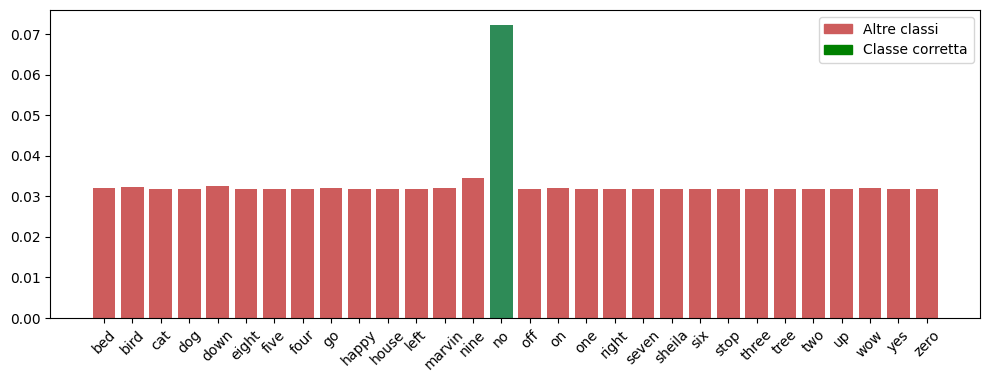

In [37]:
for audio, label in test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break